In [1]:
import random
import pandas as pd
import numpy as np
random.seed(77)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
IMAGE_SIZE = 96
IMAGE_CHANNELS = 3

SAMPLE_SIZE = 80000 # the number of images we use from each of the two classes

In [3]:
os.listdir('../input')

['test', 'train', 'train_labels.csv']

In [4]:
print(len(os.listdir('../input/train')))
print(len(os.listdir('../input/test')))

220025
57458


In [5]:
df_data = pd.read_csv('../input/train_labels.csv')

# removing this image because it caused a training error previously
df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it's black
df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']


print(df_data.shape)

(220025, 2)


In [6]:
df_data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [7]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()
    

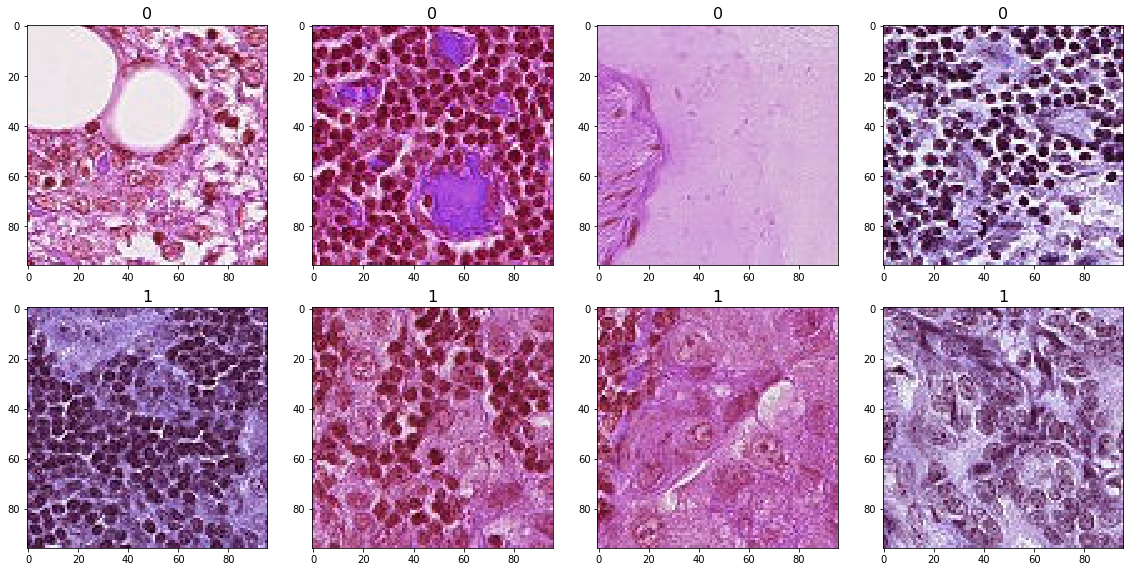

In [8]:
IMAGE_PATH = '../input/train/' 

draw_category_images('label',4, df_data, IMAGE_PATH)

In [9]:
df_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [10]:
# take a random sample of class 0 with size equal to num samples in class 1
df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state = 101)
# filter out class 1
df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state = 101)

# concat the dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# shuffle
df_data = shuffle(df_data)

df_data['label'].value_counts()

1    80000
0    80000
Name: label, dtype: int64

In [11]:
# train_test_split

# stratify=y creates a balanced validation set.
y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(144000, 2)
(16000, 2)


In [12]:
df_train['label'].value_counts()

1    72000
0    72000
Name: label, dtype: int64

In [13]:
df_val['label'].value_counts()

1    8000
0    8000
Name: label, dtype: int64

In [14]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue

# val_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue



# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)



# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)


# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)

FileExistsError: [WinError 183] 当文件已存在时，无法创建该文件。: 'base_dir'

In [15]:
# check that the folders have been created
os.listdir('base_dir/train_dir')

['a_no_tumor_tissue', 'b_has_tumor_tissue']

In [16]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)

In [17]:


# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])



# Transfer the train images

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    
    # source path to image
    src = os.path.join('../input/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    

    # source path to image
    src = os.path.join('../input/train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
    



NameError: name 'train_dir' is not defined

In [18]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir/train_dir/b_has_tumor_tissue')))


72000
72000


In [19]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir/val_dir/b_has_tumor_tissue')))


8000
8000


In [20]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = '../input/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [21]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [22]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model1 = Sequential()
model1.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model1.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model1.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model1.add(MaxPooling2D(pool_size = pool_size)) 
model1.add(Dropout(dropout_conv))

model1.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model1.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model1.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model1.add(MaxPooling2D(pool_size = pool_size))
model1.add(Dropout(dropout_conv))

model1.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model1.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model1.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model1.add(MaxPooling2D(pool_size = pool_size))
model1.add(Dropout(dropout_conv))

model1.add(Flatten())
model1.add(Dense(256, activation = "relu"))
model1.add(Dropout(dropout_dense))
model1.add(Dense(2, activation = "softmax"))

model1.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 41, 41, 64)        3

In [23]:
model1.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [24]:
# Get the labels that are associated with each index
print(val_gen.class_indices)
class ParallelModelCheckpoint(ModelCheckpoint):
    def __init__(self,model,filepath, monitor='val_loss', verbose=0,
                 save_best_only=False, save_weights_only=False,
                 mode='auto', period=1):
        self.single_model = model
        super(ParallelModelCheckpoint,self).__init__(filepath, monitor, verbose,save_best_only, save_weights_only,mode, period)

    def set_model(self, model):
        super(ParallelModelCheckpoint,self).set_model(self.single_model)

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}


In [26]:
filepath = "model1.h5"
checkpoint = ParallelModelCheckpoint(model1, filepath, monitor='accuracy', verbose = 0, 
                             save_best_only=True, mode='max', save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                                   verbose=0, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]


history1 = model1.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 14400.0 steps, validate for 1600.0 steps
Epoch 1/20
14400/14400 [==============================] - 208s 14ms/step - loss: 0.3377 - accuracy: 0.8547 - val_loss: 0.3140 - val_accuracy: 0.8634
Epoch 2/20
14400/14400 [==============================] - 171s 12ms/step - loss: 0.2913 - accuracy: 0.8782 - val_loss: 0.2751 - val_accuracy: 0.8836
Epoch 3/20
14400/14400 [==============================] - 170s 12ms/step - loss: 0.2662 - accuracy: 0.8910 - val_loss: 0.2819 - val_accuracy: 0.8752
Epoch 4/20
14400/14400 [==============================] - 172s 12ms/step - loss: 0.2263 - accuracy: 0.9092 - val_loss: 0.2140 - val_accuracy: 0.9177
Epoch 5/20
14400/14400 [==============================] - 173s 12ms/step - loss: 0.2161 - accuracy: 0.9138 - val_loss: 0.2226 - val_accuracy: 0.9139
Epoch 6/20
14400/14400 [==============================] - 174s 12ms/step - loss: 0.1945 - accuracy: 0.9237 - val_loss: 0.1946 - val_accuracy: 0.9257
Epoch

<Figure size 432x288 with 0 Axes>

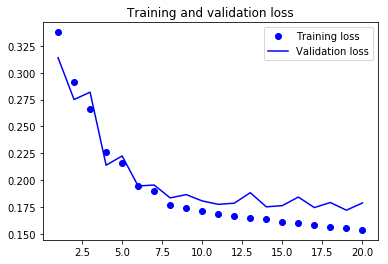

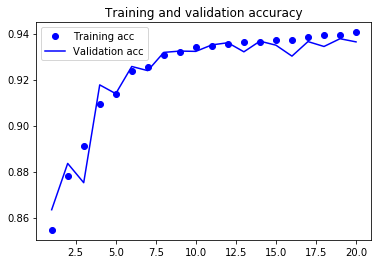

<Figure size 432x288 with 0 Axes>

In [29]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [30]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.4
dropout_dense = 0.4



model2 = Sequential()
model2.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model2.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model2.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model2.add(MaxPooling2D(pool_size = pool_size)) 
model2.add(Dropout(dropout_conv))

model2.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model2.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model2.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model2.add(MaxPooling2D(pool_size = pool_size))
model2.add(Dropout(dropout_conv))

model2.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model2.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model2.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model2.add(MaxPooling2D(pool_size = pool_size))
model2.add(Dropout(dropout_conv))

model2.add(Flatten())
model2.add(Dense(256, activation = "relu"))
model2.add(Dropout(dropout_dense))
model2.add(Dense(2, activation = "softmax"))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 43, 43, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 41, 41, 64)       

In [32]:
model2.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])


filepath = "model2.h5"
checkpoint = ParallelModelCheckpoint(model2, filepath, monitor='accuracy', verbose = 0, 
                             save_best_only=True, mode='max', save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                                   verbose=0, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]


history2 = model2.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 14400.0 steps, validate for 1600.0 steps
Epoch 1/20
14400/14400 [==============================] - 169s 12ms/step - loss: 0.4114 - accuracy: 0.8168 - val_loss: 0.4133 - val_accuracy: 0.8186
Epoch 2/20
14400/14400 [==============================] - 170s 12ms/step - loss: 0.3322 - accuracy: 0.8558 - val_loss: 0.3182 - val_accuracy: 0.8631
Epoch 3/20
14400/14400 [==============================] - 166s 12ms/step - loss: 0.2944 - accuracy: 0.8759 - val_loss: 0.2627 - val_accuracy: 0.8944
Epoch 4/20
14400/14400 [==============================] - 173s 12ms/step - loss: 0.2517 - accuracy: 0.8968 - val_loss: 0.3117 - val_accuracy: 0.8666
Epoch 5/20
14400/14400 [==============================] - 172s 12ms/step - loss: 0.2405 - accuracy: 0.9026 - val_loss: 0.2611 - val_accuracy: 0.8917
Epoch 6/20
14400/14400 [==============================] - 167s 12ms/step - loss: 0.2191 - accuracy: 0.9122 - val_loss: 0.2155 - val_accuracy: 0.9170
Epoch

<Figure size 432x288 with 0 Axes>

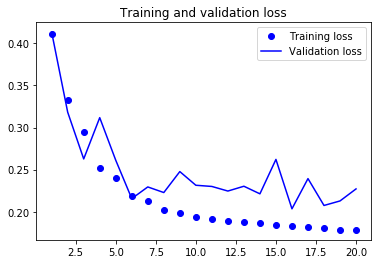

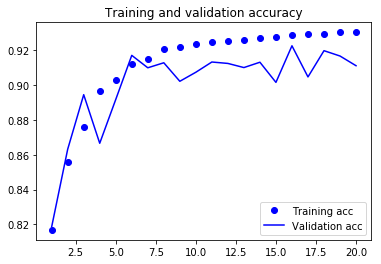

<Figure size 432x288 with 0 Axes>

In [33]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [34]:
model3 = Sequential()
model3.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (96, 96, 3)))
model3.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model3.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model3.add(Dropout(0.4))
model3.add(MaxPooling2D(pool_size = 3))

model3.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model3.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model3.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model3.add(Dropout(0.4))
model3.add(MaxPooling2D(pool_size = 3))

model3.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model3.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model3.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model3.add(Dropout(0.4))
model3.add(MaxPooling2D(pool_size = 3))

model3.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
model3.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
model3.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
model3.add(Dropout(0.4))

model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(2, activation = 'softmax'))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 96, 96, 16)        448       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 96, 96, 16)        2320      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 96, 96, 16)        2320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 96, 96, 16)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 32)       

In [35]:
model3.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])
filepath = "model3.h5"
checkpoint = ParallelModelCheckpoint(model3, filepath, monitor='accuracy', verbose = 0, 
                             save_best_only=True, mode='max', save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                                   verbose=0, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]



history3 = model3.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 14400.0 steps, validate for 1600.0 steps
Epoch 1/20
14400/14400 [==============================] - 313s 22ms/step - loss: 0.4382 - accuracy: 0.8006 - val_loss: 0.7514 - val_accuracy: 0.5804
Epoch 2/20
14400/14400 [==============================] - 147s 10ms/step - loss: 0.3552 - accuracy: 0.8461 - val_loss: 0.5794 - val_accuracy: 0.7007
Epoch 3/20
14400/14400 [==============================] - 129s 9ms/step - loss: 0.3201 - accuracy: 0.8635 - val_loss: 0.4874 - val_accuracy: 0.7909
Epoch 4/20
14400/14400 [==============================] - 127s 9ms/step - loss: 0.2749 - accuracy: 0.8851 - val_loss: 0.4805 - val_accuracy: 0.7829
Epoch 5/20
14400/14400 [==============================] - 125s 9ms/step - loss: 0.2578 - accuracy: 0.8941 - val_loss: 0.4764 - val_accuracy: 0.8107
Epoch 6/20
14400/14400 [==============================] - 128s 9ms/step - loss: 0.2332 - accuracy: 0.9055 - val_loss: 0.4513 - val_accuracy: 0.8201
Epoch 7/2

<Figure size 432x288 with 0 Axes>

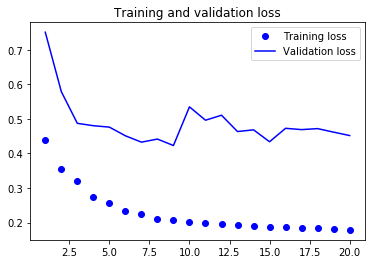

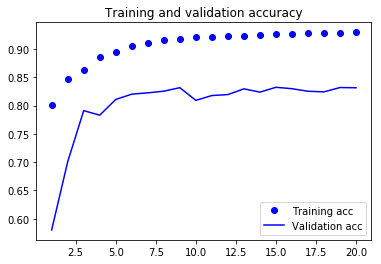

<Figure size 432x288 with 0 Axes>

In [36]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [37]:
model4 = Sequential()
model4.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (96, 96, 3)))
model4.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model4.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model4.add(Dropout(0.4))
model4.add(MaxPooling2D(pool_size = 3))

model4.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model4.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model4.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model4.add(Dropout(0.4))
model4.add(MaxPooling2D(pool_size = 3))

model4.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model4.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model4.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model4.add(Dropout(0.4))
model4.add(MaxPooling2D(pool_size = 3))

model4.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model4.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model4.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model4.add(Dropout(0.4))

model4.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same', activation = 'elu'))
model4.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same', activation = 'elu'))
model4.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same', activation = 'elu'))
model4.add(Dropout(0.4))

model4.add(Flatten())
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.4))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.4))
model4.add(Dense(2, activation = 'softmax'))
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 96, 96, 16)        448       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 96, 96, 16)        2320      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 96, 96, 16)        2320      
_________________________________________________________________
dropout_14 (Dropout)         (None, 96, 96, 16)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 32, 32)       

In [40]:
model4.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])
filepath = "model4.h5"
checkpoint = ParallelModelCheckpoint(model4, filepath, monitor='accuracy', verbose = 0, 
                             save_best_only=True, mode='max', save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                                   verbose=0, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]



history4 = model4.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 14400.0 steps, validate for 1600.0 steps
Epoch 1/20
14400/14400 [==============================] - 416s 29ms/step - loss: 0.4202 - accuracy: 0.8124 - val_loss: 0.6224 - val_accuracy: 0.6757
Epoch 2/20
14400/14400 [==============================] - 136s 9ms/step - loss: 0.3422 - accuracy: 0.8510 - val_loss: 0.5228 - val_accuracy: 0.7607
Epoch 3/20
14400/14400 [==============================] - 138s 10ms/step - loss: 0.2972 - accuracy: 0.8747 - val_loss: 0.4921 - val_accuracy: 0.7731
Epoch 4/20
14400/14400 [==============================] - 138s 10ms/step - loss: 0.2493 - accuracy: 0.8979 - val_loss: 0.4330 - val_accuracy: 0.8154
Epoch 5/20
14400/14400 [==============================] - 141s 10ms/step - loss: 0.2339 - accuracy: 0.9048 - val_loss: 0.4867 - val_accuracy: 0.7921
Epoch 6/20
14400/14400 [==============================] - 141s 10ms/step - loss: 0.2100 - accuracy: 0.9158 - val_loss: 0.4725 - val_accuracy: 0.8080
Epoch 

<Figure size 432x288 with 0 Axes>

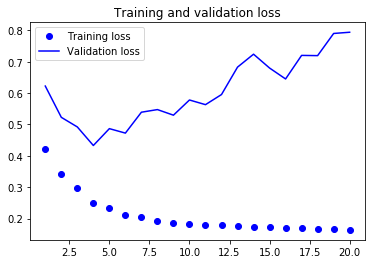

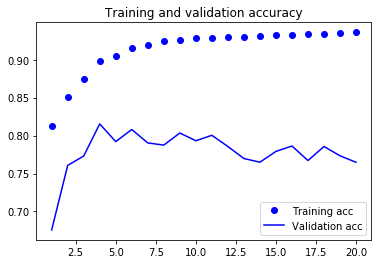

<Figure size 432x288 with 0 Axes>

In [41]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()